# Matchup Analysis

### MSP 7.1.2017

It's time. Fivethirtyeight has their model, we need one of our own.

This model will update daily.

In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# imports for scraping

from bs4 import BeautifulSoup

import requests


In [3]:
teams = ['angels','astros','athletics','bluejays','braves',\
        'brewers','cardinals','cubs','diamondbacks','dodgers',\
        'giants','indians','mariners','marlins','mets','nationals',\
        'orioles','padres','phillies','pirates','rangers',\
        'rays','redsox','rockies','royals','tigers','twins',\
        'whitesox','yankees']

# can go back seasons with ?season=2016 at end of url

In [4]:
# get twins data
#teams = ['twins']

Schedule = {}


for inteam in teams:
    
    print inteam+' ',
    
    Schedule[inteam] = {}
    
    r  = requests.get('http://www.fangraphs.com/teams/'+inteam+'/schedule')

    data = r.text

    soup = BeautifulSoup(data)

    table_div = soup.find('div' , {"class":"team-schedule-table"})
    table = table_div.find('table')

    # The first tr contains the field names.
    headings = [th.get_text() for th in table.find("tr").find_all("th")]

    # get number of games played
    ngames = 0
    for row in table.find_all("tr")[1:]:
        if [td.get_text() for td in row.find_all("td")][5] != '':
            ngames += 1       
        

    headings[3] = 'HomeWin'
    headings[5] = 'HomeRuns'
    headings[7] = 'HomeStarter'

    #print headings


    for indx,val in enumerate(headings):
        Schedule[inteam][val] = np.empty(ngames,dtype='S20')

    game = 0
    for row in table.find_all("tr")[1:]:
        if [td.get_text() for td in row.find_all("td")][5] != '':
            for indx,val in enumerate(headings):
                Schedule[inteam][val][game] = [td.get_text().decode() for td in row.find_all("td")][indx]
            game += 1


angels  astros  athletics  bluejays  braves  brewers  cardinals  cubs  diamondbacks  dodgers  giants  indians  mariners  marlins  mets  nationals  orioles  padres  phillies  pirates  rangers  rays  redsox  rockies  royals  tigers  twins  whitesox  yankees 


In [24]:
for day in Schedule['twins']['Date']:
    print day.split()

['Apr', '3,', '20174/3']
['Apr', '5,', '20174/5']
['Apr', '6,', '20174/6']
['Apr', '7,', '20174/7']
['Apr', '8,', '20174/8']
['Apr', '9,', '20174/9']
['Apr', '11,', '20174/11']
['Apr', '12,', '20174/12']
['Apr', '13,', '20174/13']
['Apr', '14,', '20174/14']
['Apr', '15,', '20174/15']
['Apr', '16,', '20174/16']
['Apr', '17,', '20174/17']
['Apr', '18,', '20174/18']
['Apr', '20,', '20174/20']
['Apr', '21,', '20174/21']
['Apr', '22,', '20174/22']
['Apr', '23,', '20174/23']
['Apr', '24,', '20174/24']
['Apr', '25,', '20174/25']
['Apr', '26,', '20174/26']
['Apr', '28,', '20174/28']
['Apr', '30,', '20174/30']
['May', '2,', '20175/2']
['May', '3,', '20175/3']
['May', '4,', '20175/4']
['May', '5,', '20175/5']
['May', '6,', '20175/6']
['May', '7,', '20175/7']
['May', '9,', '20175/9']
['May', '11,', '20175/11']
['May', '12,', '20175/12']
['May', '13,', '20175/13']
['May', '14,', '20175/14']
['May', '16,', '20175/16']
['May', '18,', '20175/18']
['May', '18,', '20175/18']
['May', '19,', '20175/19']


What about checking over a specific date range to see how run differential is coming along?

In [27]:

overgames = -20
rdiff = {}
for inteam in teams:

    rdiff[inteam] = np.sum(Schedule[inteam]['HomeRuns'][overgames:-1].astype(float) - Schedule[inteam]['OppRuns'][overgames:-1].astype(float))

import operator
sorted_x = sorted(rdiff.items(), key=operator.itemgetter(1)) 

print 


for tupl in sorted_x[::-1]:

    print '{0:<12s} {1:>6.1f}'.format(tupl[0],tupl[1])
                                 
                                 




cubs           34.0
dodgers        25.0
yankees        19.0
astros         19.0
indians        19.0
orioles        18.0
nationals      17.0
phillies       13.0
royals         13.0
rockies        13.0
diamondbacks   12.0
cardinals      11.0
tigers          6.0
mariners        4.0
athletics       3.0
mets            3.0
marlins         2.0
angels          1.0
redsox          1.0
pirates         1.0
padres         -8.0
rays          -10.0
braves        -13.0
bluejays      -18.0
giants        -19.0
brewers       -20.0
twins         -22.0
rangers       -29.0
whitesox      -53.0


In [5]:

rdiff = {}
for inteam in teams:

    rdiff[inteam] = np.sum(Schedule[inteam]['HomeRuns'].astype(float) - Schedule[inteam]['OppRuns'].astype(float))

import operator
sorted_x = sorted(rdiff.items(), key=operator.itemgetter(1)) 

print 


for tupl in sorted_x[::-1]:

    print '{0:<12s} {1:>6.1f}'.format(tupl[0],tupl[1])
                                 
                                 


dodgers       187.0
astros        161.0
diamondbacks  117.0
yankees       112.0
nationals     108.0
indians        99.0
redsox         70.0
rockies        47.0
cubs           43.0
brewers        24.0
cardinals      23.0
rays            8.0
rangers         3.0
mariners       -2.0
angels        -10.0
royals        -10.0
marlins       -12.0
tigers        -23.0
pirates       -29.0
mets          -47.0
braves        -60.0
orioles       -62.0
twins         -75.0
bluejays      -78.0
whitesox      -79.0
phillies      -86.0
athletics     -94.0
giants       -109.0
padres       -133.0


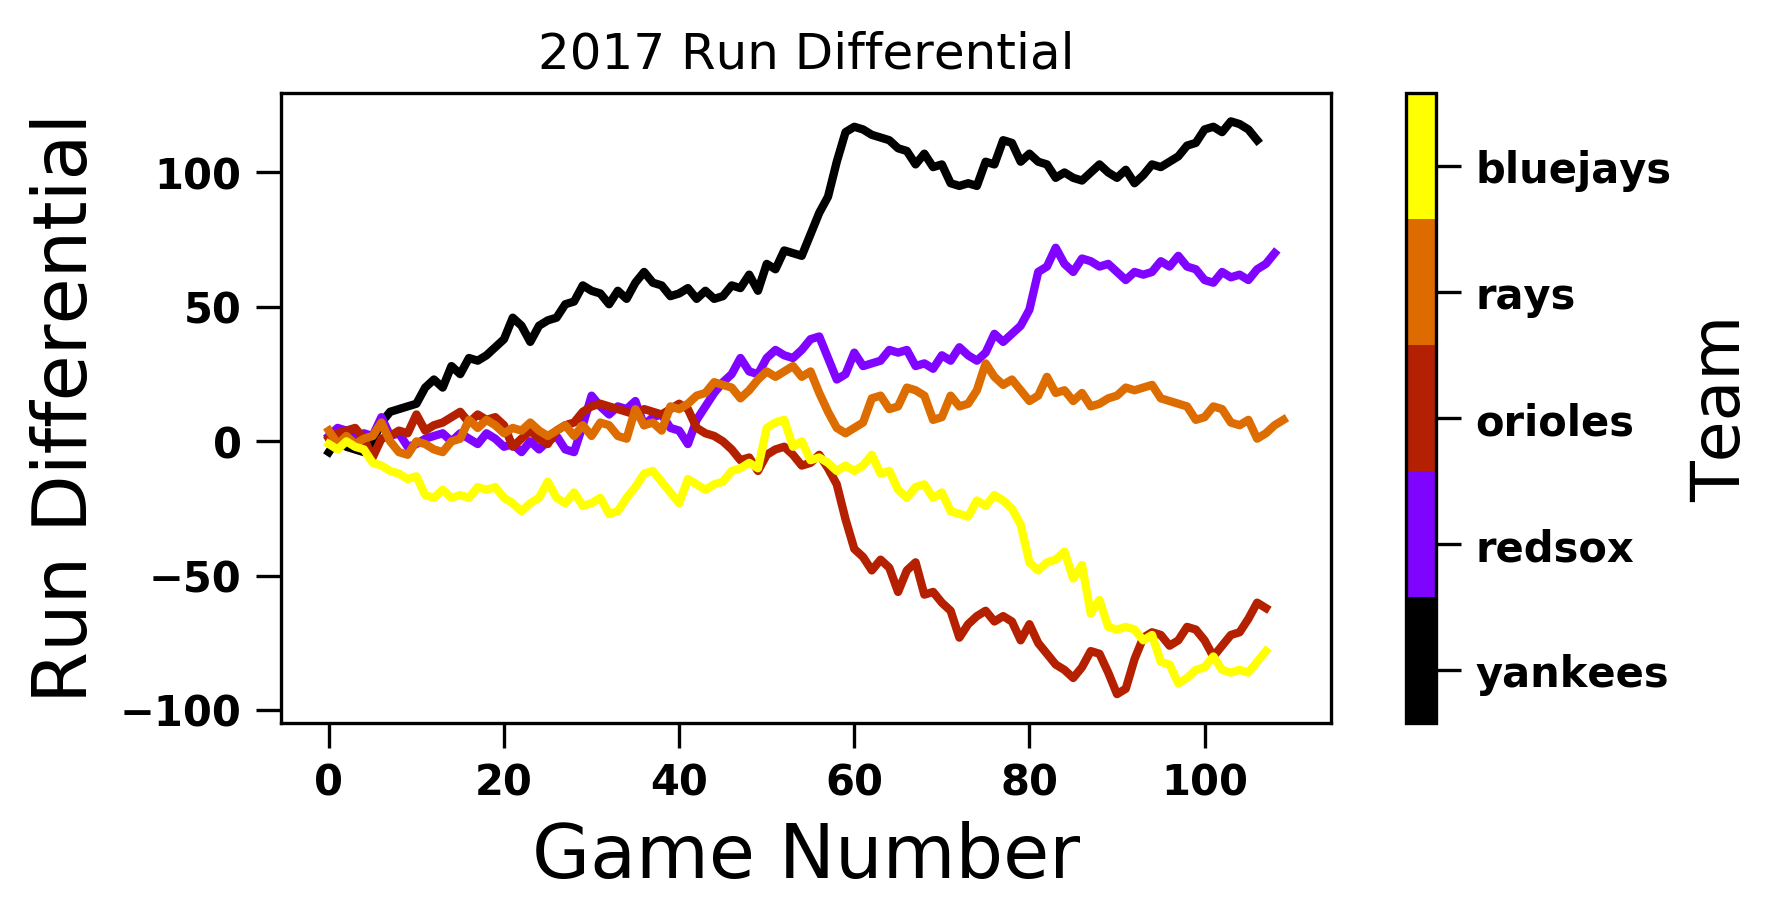

In [20]:
fig = plt.figure(figsize=(5,3))

ax1 = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


teams2 = ['yankees','redsox','orioles','rays','bluejays']

clrs = cm.gnuplot

for indx,inteam in enumerate(teams2):

    ax1.plot(np.cumsum(Schedule[inteam]['HomeRuns'].astype(float) - Schedule[inteam]['OppRuns'].astype(float)),color=cm.gnuplot(indx/float(len(teams2)-1.),1.))
    
 
import matplotlib as mpl

norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(0,1.,len(teams2)+1.), ncolors=256)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Team',size=16)
cb1.set_ticks(np.linspace(0.,1.,len(teams2)+1.) + 0.5/(len(teams2)+1.))
cb1.set_ticklabels(teams2)


    
    
ax1.set_title('2017 Run Differential')
ax1.set_xlabel('Game Number',size=18)    
ax1.set_ylabel('Run Differential',size=18)

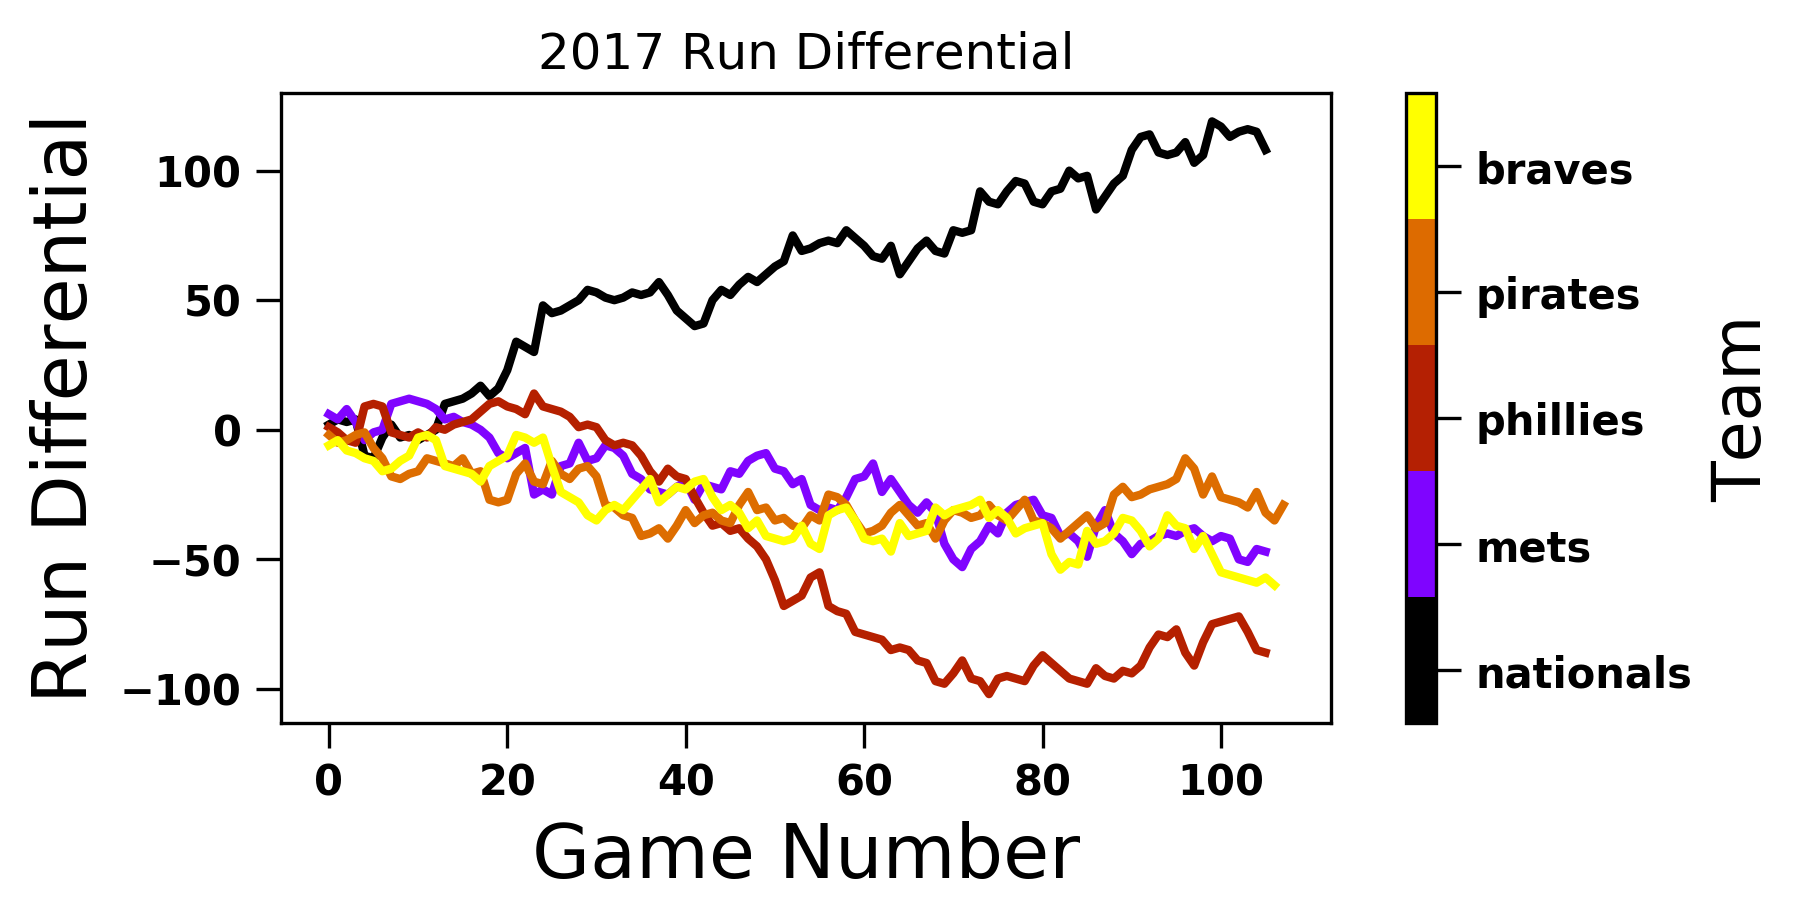

In [21]:
fig = plt.figure(figsize=(5,3))

ax1 = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


teams2 = ['nationals','mets','phillies','pirates','braves']

clrs = cm.gnuplot

for indx,inteam in enumerate(teams2):

    ax1.plot(np.cumsum(Schedule[inteam]['HomeRuns'].astype(float) - Schedule[inteam]['OppRuns'].astype(float)),color=cm.gnuplot(indx/float(len(teams2)-1.),1.))
    
 
import matplotlib as mpl

norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(0,1.,len(teams2)+1.), ncolors=256)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Team',size=16)
cb1.set_ticks(np.linspace(0.,1.,len(teams2)+1.) + 0.5/(len(teams2)+1.))
cb1.set_ticklabels(teams2)


    
    
ax1.set_title('2017 Run Differential')
ax1.set_xlabel('Game Number',size=18)    
ax1.set_ylabel('Run Differential',size=18)

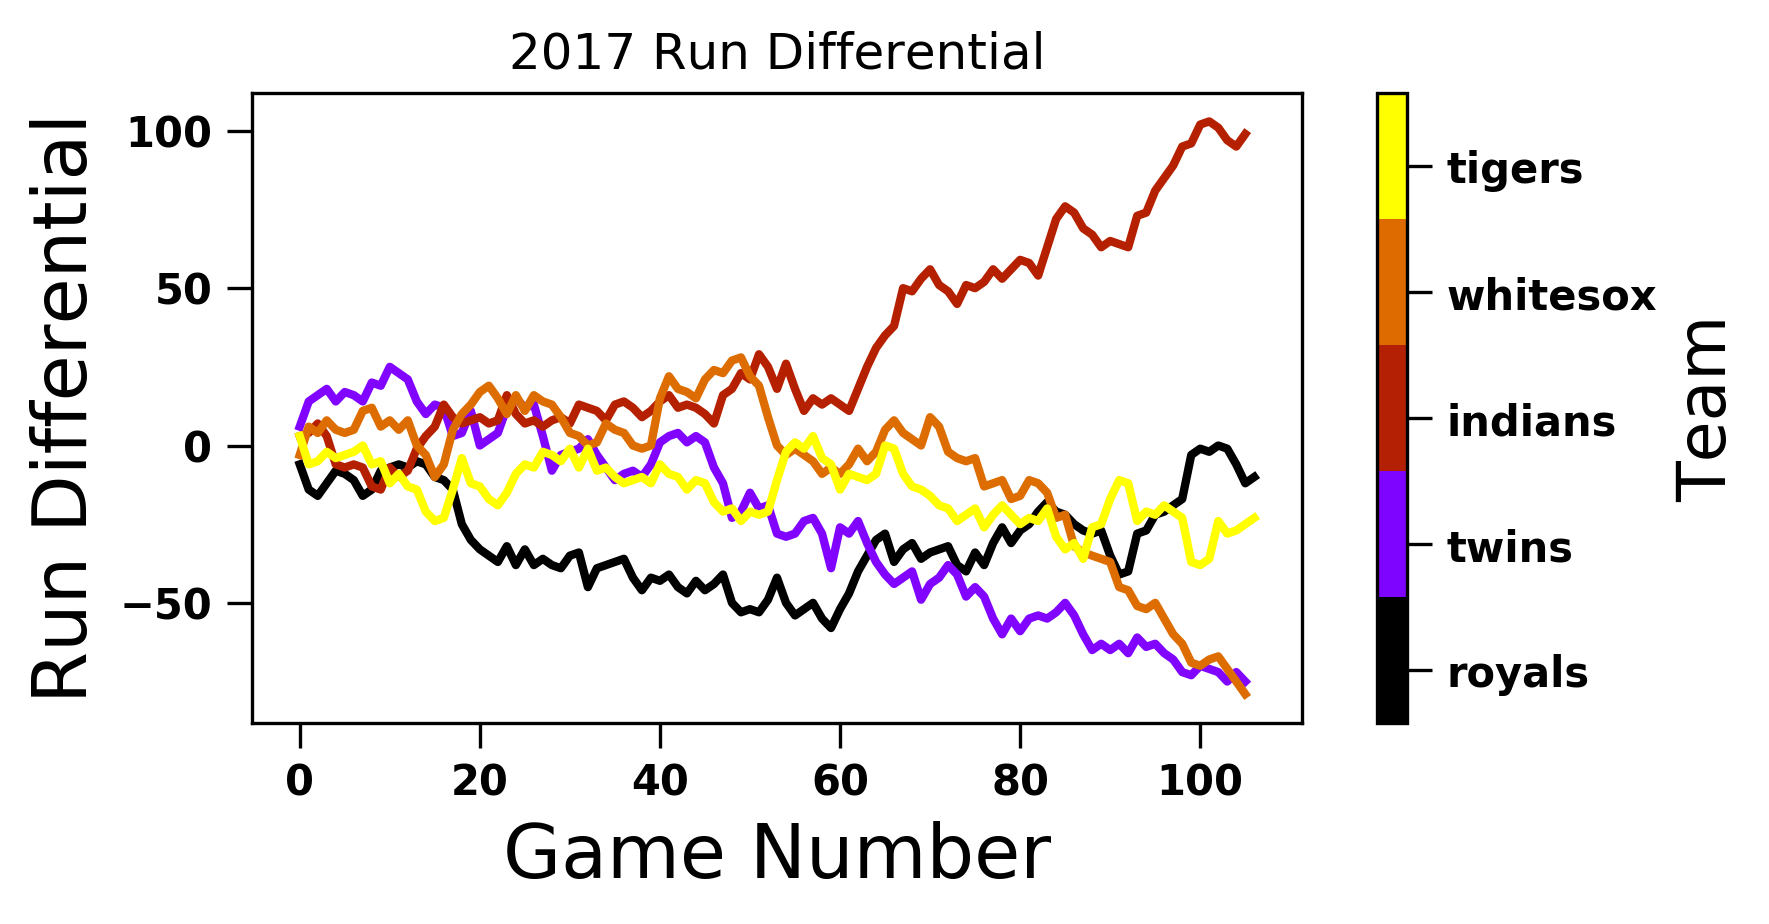

In [28]:
fig = plt.figure(figsize=(5,3))

ax1 = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


teams2 = ['royals','twins','indians','whitesox','tigers']

clrs = cm.gnuplot

for indx,inteam in enumerate(teams2):

    ax1.plot(np.cumsum(Schedule[inteam]['HomeRuns'].astype(float) - Schedule[inteam]['OppRuns'].astype(float)),color=cm.gnuplot(indx/float(len(teams2)-1.),1.))
    
 
import matplotlib as mpl

norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(0,1.,len(teams2)+1.), ncolors=256)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Team',size=16)
cb1.set_ticks(np.linspace(0.,1.,len(teams2)+1.) + 0.5/(len(teams2)+1.))
cb1.set_ticklabels(teams2)


    
    
ax1.set_title('2017 Run Differential')
ax1.set_xlabel('Game Number',size=18)    
ax1.set_ylabel('Run Differential',size=18)

Quick thoughts (on 7/1/2017):
1. What's going on with the Orioles??
2. Padres look like they have a commanding lead on being bad.
3. Dodgers look very good on the top end.
4. Big nose-dive for the Rockies lately. Time to start against them away?

Quick thoughts on 8/5/2017:
1. After the Astros went on a tear, the Dodgers looked beatable, but now the Dodgers are back on top.
2. The Padres are still bad, but the Giants have been giving them a run for their money.

### Goal: make a model for teams facing each other that can be built from.


### Checkpoint: Examining starters

What kind of a lead or deficit are starters leaving with?

In [7]:
    
teams2 = ['indians','royals','whitesox','tigers','twins']

GameLog = {}


for inteam in teams:

        print inteam,

        GameLog[inteam] = {}

        r  = requests.get('http://www.fangraphs.com/teams/'+inteam+'/schedule')

        data = r.text

        soup = BeautifulSoup(data)

        table_div = soup.find('div' , {"class":"team-schedule-table"})
        table = table_div.find('table')

        # The first tr contains the field names.
        headings = [th.get_text() for th in table.find("tr").find_all("th")]

        #print headings

        # get number of games played
        ngames = 0
        for row in table.find_all("tr")[1:]:
            if [td.get_text() for td in row.find_all("td")][5] != '':
                GameLog[inteam][ngames] = {}
                sav = [td.find('a') for td in row.find_all("td")][0]
                GameLog[inteam][ngames]['link'] = sav.get('href')[0:25]+'plays'+sav.get('href')[29:]
                GameLog[inteam][ngames]['oppo'] = [td.get_text() for td in row.find_all("td")][8]
                GameLog[inteam][ngames]['home'] = [td.get_text() for td in row.find_all("td")][7]
                GameLog[inteam][ngames]['date'] = [td.get_text() for td in row.find_all("td")][0]
                ngames += 1       



print GameLog.keys()

angels astros athletics bluejays braves brewers cardinals cubs diamondbacks dodgers giants indians mariners marlins mets nationals orioles padres phillies pirates rangers rays redsox rockies royals tigers twins whitesox yankees ['mets', 'rockies', 'pirates', 'marlins', 'redsox', 'royals', 'rays', 'indians', 'rangers', 'twins', 'brewers', 'orioles', 'angels', 'phillies', 'giants', 'bluejays', 'dodgers', 'astros', 'cardinals', 'cubs', 'diamondbacks', 'mariners', 'yankees', 'braves', 'tigers', 'athletics', 'whitesox', 'nationals', 'padres']


In [101]:
teams2 = ['mariners']

starter_off = {}
starter_def = {}


for inteam in teams2:
    
    print inteam

    starter_off[inteam] = np.zeros(len(GameLog[inteam].keys()))
    starter_def[inteam] = np.zeros(len(GameLog[inteam].keys()))



    
    for indx,key in enumerate(GameLog[inteam].keys()):
 
        print 'Game number: ',indx+1,
    
        r  = requests.get(GameLog[inteam][key]['link'])
    
        #print GameLog[key]['link']
        print GameLog[inteam][key]['oppo'],

        data = r.text
    
        soup = BeautifulSoup(data)

        table = soup.findAll('table')[8]
        # The first tr contains the field names.
        headings = [th.get_text() for th in table.find("tr").find_all("th")]

        #print headings
        # get number of games played
        #ngames = 0
        nruns_o = 0.
        nruns_d = 0.
        for row in table.find_all("tr")[1:]:
            if GameLog[inteam][key]['oppo'].split()[1] in [td.get_text() for td in row.find_all("td")][0]:
                up = int([td.get_text() for td in row.find_all("td")][13])
                #print ~int([td.get_text() for td in row.find_all("td")][13])
                breakscore = [td.get_text() for td in row.find_all("td")][5].split('-')
                #print [td.get_text() for td in row.find_all("td")][2],up,[td.get_text() for td in row.find_all("td")][0],breakscore[0],breakscore[1]
                
                if up:
                    tmpruns_o = float(breakscore[0])
                else:
                    tmpruns_o = float(breakscore[1])
                    
                nruns_o = np.max([nruns_o,tmpruns_o])
                
                
            if GameLog[inteam][key]['home'].split()[1] in [td.get_text() for td in row.find_all("td")][0]:
                up = int([td.get_text() for td in row.find_all("td")][13])
                #print ~int([td.get_text() for td in row.find_all("td")][13])
                breakscore = [td.get_text() for td in row.find_all("td")][5].split('-')
                #print [td.get_text() for td in row.find_all("td")][2],up,[td.get_text() for td in row.find_all("td")][0],breakscore[0],breakscore[1]
                
                if up:
                    tmpruns_d = float(breakscore[0])
                else:
                    tmpruns_d = float(breakscore[1])
                    
                nruns_d = np.max([nruns_d,tmpruns_d])
                
        print nruns_o,nruns_d
        
        starter_off[inteam][indx] = nruns_o # runs scored by team
        starter_def[inteam][indx] = nruns_d # runs scored against team



mariners
Game number:  1 Dallas Keuchel 0.0 2.0
Game number:  2 Lance McCullers 1.0 2.0
Game number:  3 Charlie Morton 2.0 0.0
Game number:  4 Joe Musgrove 1.0 2.0
Game number:  5 Jesse Chavez 1.0 3.0
Game number:  6 Ricky Nolasco 2.0 3.0
Game number:  7 Matt Shoemaker 6.0 1.0
Game number:  8 Charlie Morton 3.0 0.0
Game number:  9 Joe Musgrove 3.0 2.0
Game number:  10 Mike Fiers 5.0 4.0
Game number:  11 Martin Perez 1.0 1.0
Game number:  12 Andrew Cashner 2.0 0.0
Game number:  13 Cole Hamels 4.0 6.0
Game number:  14 Tom Koehler 5.0 0.0
Game number:  15 Wei-Yin Chen 0.0 4.0
Game number:  16 Edinson Volquez 4.0 4.0
Game number:  17 Cesar Valdez 3.0 5.0
Game number:  18 Sean Manaea 1.0 2.0
Game number:  19 Jharel Cotton 2.0 4.0
Game number:  20 Andrew Triggs 6.0 0.0
Game number:  21 Jordan Zimmermann 5.0 4.0
Game number:  22 Daniel Norris 3.0 0.0
Game number:  23 Justin Verlander 1.0 1.0
Game number:  24 Carlos Carrasco 3.0 1.0
Game number:  25 Danny Salazar 3.0 4.0
Game number:  26 Josh 

#### The American League Central

indians 13.0
royals -16.0
whitesox -19.0
tigers 1.0
twins -13.0


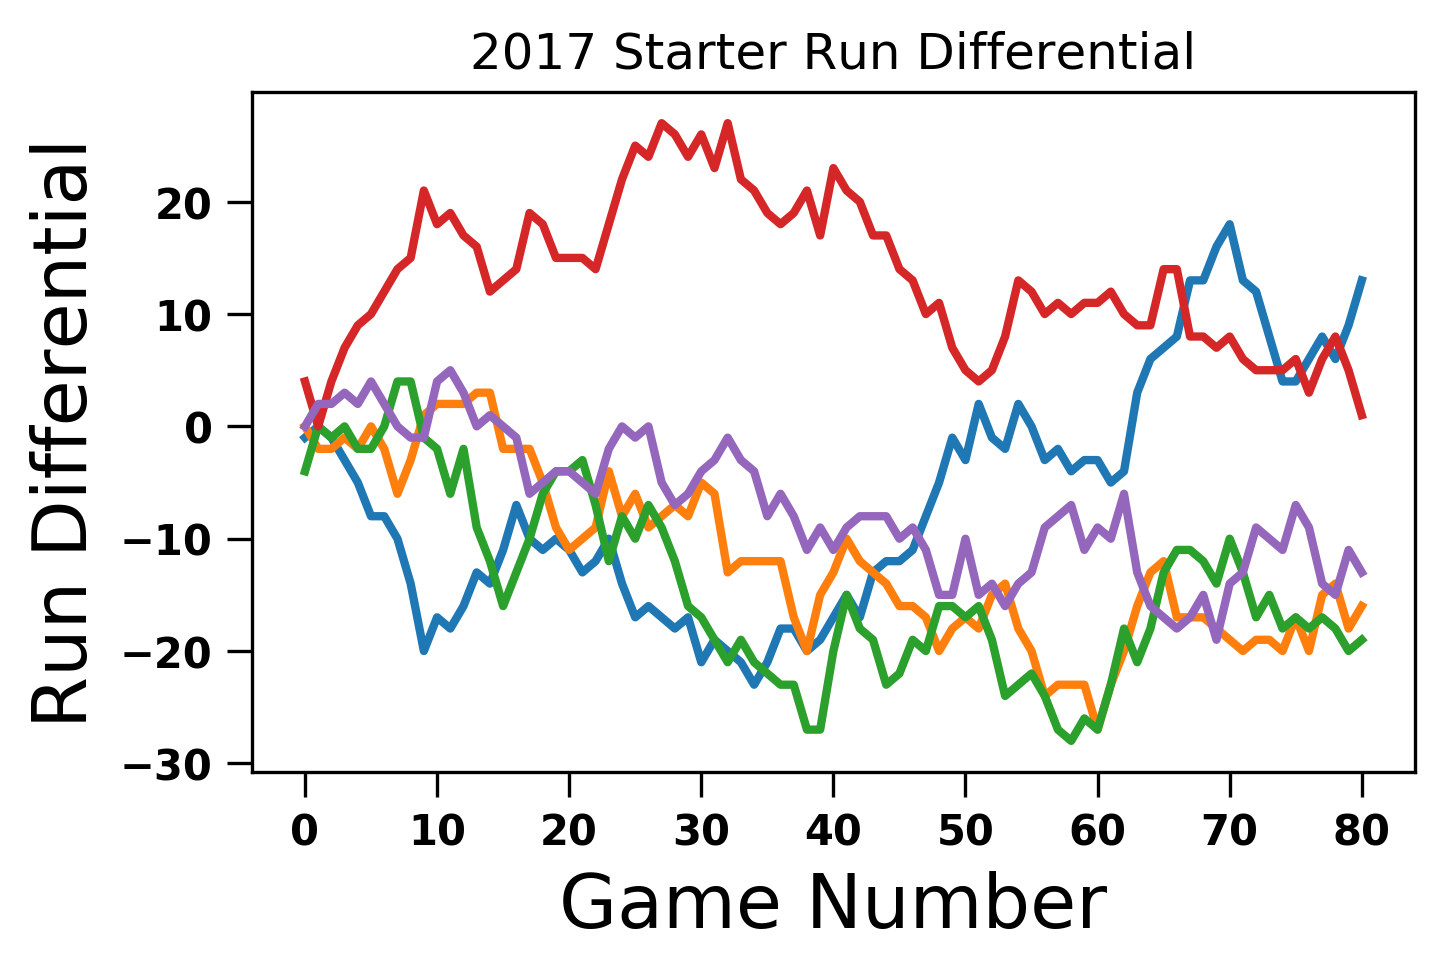

In [85]:
plt.figure(figsize=(5,3))


for inteam in teams2:

    print inteam,np.cumsum(starter_off[inteam]-starter_def[inteam])[-1]
    plt.plot(np.cumsum(starter_off[inteam]-starter_def[inteam]))

plt.title('2017 Starter Run Differential')
plt.xlabel('Game Number',size=18)    
plt.ylabel('Run Differential',size=18)

In [117]:
teams2 = ['mariners']
pname = 'Paxton'
pa_num = 0

for inteam in teams2:
    
    print inteam

    for indx,key in enumerate(GameLog[inteam].keys()):
 
        if pname in GameLog[inteam][key]['home']:
            print '\n\nDate: ',GameLog[inteam][key]['date'].split(',')[0]
    
        r  = requests.get(GameLog[inteam][key]['link'])
    
        #print GameLog[key]['link']
        #print GameLog[inteam][key]['oppo'],

        data = r.text
    
        soup = BeautifulSoup(data)

        table = soup.findAll('table')[8]

        headings = [th.get_text() for th in table.find("tr").find_all("th")]
        #print headings

        for row in table.find_all("tr")[1:]:
            if pname in [td.get_text() for td in row.find_all("td")][0]:
                
                if ('scored' in [td.get_text() for td in row.find_all("td")][6]) |\
                ('homered' in [td.get_text() for td in row.find_all("td")][6]):
                    print pa_num,[td.get_text() for td in row.find_all("td")][6]
                
                    pa_num += 1
                

mariners


Date:  Apr 5


Date:  Apr 10


Date:  Apr 15


Date:  Apr 20
0 Adam Rosales singled to right (Liner). Jaff Decker scored. Rajai Davis scored on error. Adam Rosales advanced to 2B. Error by Mitch Haniger.
1 Ryon Healy doubled to left (Liner). Adam Rosales scored.
2 Adam Rosales hit a sacrifice fly to center (Fliner (Fly)). Rajai Davis scored.
3 Ryon Healy singled to left (Liner). Jed Lowrie scored. Khris Davis advanced to 2B.


Date:  Apr 26


Date:  May 2
4 Cameron Maybin hit a ground rule double (Fliner (Liner)). Andrelton Simmons scored.
5 Jefry Marte hit a sacrifice fly to center (Fly). Mike Trout scored. Albert Pujols advanced to 2B.


Date:  May 31


Date:  Jun 6
6 Brian Dozier homered (Fly).
7 Max Kepler reached on fielder's choice to second (Grounder). Miguel Sano scored. Robbie Grossman out at second.
8 Joe Mauer singled to center (Liner). Byron Buxton scored. Brian Dozier advanced to 3B.


Date:  Jun 11
9 Josh Donaldson homered (Fly). Kevin Pillar scored.
10 Josh Do

In [10]:
teams2 = ['orioles']
pname = 'Britton'
pa_num = 0

for inteam in teams2:
    
    print inteam

    for indx,key in enumerate(GameLog[inteam].keys()):
 
        if pname in GameLog[inteam][key]['home']:
            print '\n\nDate: ',GameLog[inteam][key]['date'].split(',')[0]
    
        r  = requests.get(GameLog[inteam][key]['link'])
    
        #print GameLog[key]['link']
        #print GameLog[inteam][key]['oppo'],

        data = r.text
    
        soup = BeautifulSoup(data)

        table = soup.findAll('table')[8]

        headings = [th.get_text() for th in table.find("tr").find_all("th")]
        #print headings

        for row in table.find_all("tr")[1:]:
            if pname in [td.get_text() for td in row.find_all("td")][0]:
                
                #if ('scored' in [td.get_text() for td in row.find_all("td")][6]) |\
                #('homered' in [td.get_text() for td in row.find_all("td")][6]):
                    print pa_num,[td.get_text() for td in row.find_all("td")][6]
                
                    pa_num += 1
                

orioles
0 Darwin Barney struck out swinging.
1 Devon Travis singled to shortstop (Grounder).
2 Josh Donaldson singled to left (Grounder). Devon Travis advanced to 2B.
3 Jose Bautista grounded into a double play to third (Grounder). Josh Donaldson out at second.
4 Kendrys Morales grounded out to third (Grounder).
5 Troy Tulowitzki grounded out to shortstop (Grounder).
6 Russell Martin walked.
7 Steve Pearce singled to left (Liner). Russell Martin advanced to 2B.
8 Kevin Pillar grounded out to third (Grounder).
9 Jose Bautista singled to left (Fliner (Liner)).
10 Kendrys Morales singled to left (Grounder). Jose Bautista advanced to 2B.
11 Troy Tulowitzki struck out swinging.
12 Russell Martin walked. Jose Bautista advanced to 3B. Ryan Goins advanced to 2B.
13 Steve Pearce grounded into a double play to shortstop (Grounder). Russell Martin out at second.
14 Brett Gardner struck out looking.
15 Gary Sanchez grounded out to pitcher (Grounder).
16 Chris Carter grounded out to third (Grounder

In [12]:
teams2 = ['mariners']
pname = 'Zunino'
pa_num = 0

for inteam in teams2:
    
    print inteam

    for indx,key in enumerate(GameLog[inteam].keys()):
 
        if pname in GameLog[inteam][key]['home']:
            print '\n\nDate: ',GameLog[inteam][key]['date'].split(',')[0]
    
        r  = requests.get(GameLog[inteam][key]['link'])
    
        #print GameLog[key]['link']
        #print GameLog[inteam][key]['oppo'],

        data = r.text
    
        soup = BeautifulSoup(data)

        table = soup.findAll('table')[8]

        headings = [th.get_text() for th in table.find("tr").find_all("th")]
        #print headings

        for row in table.find_all("tr")[1:]:
            if pname in [td.get_text() for td in row.find_all("td")][1]:
                
                #if ('scored' in [td.get_text() for td in row.find_all("td")][6]) |\
                #('homered' in [td.get_text() for td in row.find_all("td")][6]):
                    print pa_num,[td.get_text() for td in row.find_all("td")][6]
                
                    pa_num += 1
                

mariners
0 Mike Zunino grounded out to second (Grounder).
1 Mike Zunino grounded out to shortstop (Grounder).
2 Mike Zunino grounded out to third (Grounder).
3 Mike Zunino struck out looking.
4 Mike Zunino grounded out to shortstop (Grounder).
5 Mike Zunino singled to shortstop (Grounder). Danny Valencia advanced to 2B.
6 Mike Zunino struck out swinging.
7 Mike Zunino doubled to center (Fliner (Fly)).
8 Mike Zunino grounded out to shortstop (Grounder).
9 Mike Zunino flied out to left (Fly).
10 Mike Zunino struck out swinging.
11 Mike Zunino flied out to center (Fly).
12 Mike Zunino struck out swinging.
13 Mike Zunino singled to left (Fliner (Liner)).
14 Mike Zunino struck out swinging.
15 Mike Zunino struck out swinging.
16 Mike Zunino flied out to third (Fly).
17 Mike Zunino flied out to pitcher (Fly).
18 Mike Zunino struck out swinging.
19 Mike Zunino singled to center (Grounder). Kyle Seager scored.
20 Mike Zunino struck out swinging.
21 Mike Zunino singled to left (Fliner (Liner)).